# BERT:为语言理解而生的深层双向Transformers预培训模型
雅各布·德夫林·张明伟·肯顿·李·克里斯蒂娜·图塔诺娃

谷歌人工智能语言

{jacobdevlin, mingweichang、kentonl kristout} @google.com

# 摘要
介绍了一种新的语言表示模型BERT，它是在Transformers上的双向编码器表示。不像最近的语言表达模型，BERT旨在通过在所有层中对左右上下文进行联合调节，预先训练来自未标记文本的深层双向表示。因此，只需一个额外的输出层，就可以对预先训练好的BERT模型进行微调，从而为各种各样的任务(如回答问题和语言推理)创建最先进的模型，而无需对特定于任务的体系结构进行实质性的修改。

BERT在概念上很简单，在经验上很强大。它在11项自然语言处理任务上获得了最新的技术成果，包括将GLUE(一般语言理解评估)的分数提高到80.5%(绝对提高7.7%)，多项精度为86.7%(绝对提高4.6%)，队v1.1答题测试F1至93.2(绝对提高1.5分)，队v2.0测试F1至83.1(绝对提高5.1分)。

# 1介绍
语言模型预处理已被证明对提高许多自然语言处理任务是有效的。这些任务包括句子级任务，如自然语言推理和释义，其目的是通过整体分析来预测句子之间的关系，以及标记级任务，如命名实体识别和问题回答，这些任务要求模型在标记级生成细粒度输出。

目前有两种策略可以将预先训练好的语言表示应用于下游任务:基于特性的和微调。基于特性的方法，例如ELMo，使用特定于任务的体系结构，其中包括作为附加特性的预先训练的表示。微调方法，例如生成式预训练Transformer(OpenAI GPT)，引入最小的特定于任务的参数，并通过简单地微调所有预训练参数，对下游任务进行培训。这两种方法在训练前具有相同的目标功能，它们使用单向语言模型来学习一般的语言表示。

我们认为，当前的技术限制了预训练表示的能力，特别是对于微调方法。主要的限制是标准语言模型是单向的，这限制了在预训练使用的体系结构的选择。例如，在OpenAI GPT中，作者使用了从左到右的体系结构，其中每个字符只能处理转换器的自关注层中以前的字符。这样的限制对于句子级任务来说不是最优的，当将基于调优的方法应用于符号级任务(例如问答)时可能非常有害，因为在这些任务中，从两个方向对合并上下文都是至关重要的。

在本文中，我们改进了基于微调的方法，提出了BERT:双向编码器表示的Transformer。BERT在完成完形填空任务的启发下，通过使用“掩蔽语言模型”(MLM)预训练目标，减轻了前面提到的单向性约束。掩码语言模型随机地对输入中的一些标记进行掩码，其目标是仅根据上下文预测掩码单词的原始词汇表id。与从左到右的语言模型预训练不同，MLM目标使表示能够融合左上下文和右上下文，从而使我们能够预训练一个深层双向转换器。除了掩蔽语言模型之外，我们还使用了一个“下一个句子预测”任务来联合预训练文本对表示。本文的贡献如下:

- 我们展示了语言表达的双向预培训的重要性。与Radford等人(2018)使用单向语言模型进行预训练不同，BERT使用掩MLM蔽语言模型实现预训练的深层双向表示。这也与Peters等人(2018a)形成对比，Peters等人使用独立训练的从左到右和从右到左LMs的浅连接。
- 我们表明，预训练的表示减少了对许多高工程化的特定于任务的体系结构的需求。BERT是第一个基于精细调优的表示模型，它在大量语句级和词级任务上实现了最先进的性能，性能优于许多特定于任务的体系结构。
- BERT为11项NLP任务提升了技术水平。代码和预培训的模型可以在https://github.com/googel -research/bert上找到。



# 2相关工作
预训练在一般语言表示上已有很长的历史，在本节中，我们简要回顾了最广泛使用的方法。

## 2.1无监督特征的方法
数十年来，学习广泛应用的单词表示一直是一个活跃的研究领域，包括非神经和神经方法。预先训练的词嵌入是现代NLP系统的一个重要组成部分，相对于从零开始学习的嵌入，它提供了显著的改进。为了预先训练单词嵌入向量，使用了从左到右的语言建模目标，以及在左右上下文中区分正确和错误的单词。

这些方法已经被推广到更粗的粒度，例如句子嵌入或段落嵌入。为了训练句子的表达，之前的工作已经使用目标来对候选的下一个句子进行排序，给定一个前一个句子的表示，从左到右生成下一个句子单词，或者对自动编码器派生的目标进行去噪。

ELMo及其前身从不同的维度概括了传统的词嵌入研究。它们从从左到右和从右到左的语言模型中提取上下文敏感的特性。每个词的上下文表示是左到右和右到左表示的连接。整合与现有的特定于任务的上下文字嵌入的架构时,ELMo为几个主要的NLP基准提高了技术水平，包括：问答,情感分析,命名实体识别等。(2016)提出学习上下文表示通过任务来预测一个字从左和右使用LSTMs上下文。与ELMo类似，他们的模型是基于特征的，不是深度双向的。Fedus等(2018)研究表明，完形填空任务可以提高文本生成模型的鲁棒性。

## 2.2无监督微调的方法
与基于特征的方法一样，第一种方法在这个方向上只能从未标记的文本中预先训练单词嵌入参数。

最近，产生上下文词表示的句子或文档编码器已经从未标记的文本中进行了预训练，并为受监督的下游任务进行了微调。这些方法的优点是，很少需要从头学习参数。至少部分由于这个优势，OpenAI GPT在GLUE基准测试的许多语句级任务上实现了以前最先进的结果。从左到右的语言建模和自动编码器目标已用于此类模型的预培训。

## 2.3从监督数据中迁移学习
也有研究表明，使用大型数据集(如自然语言推理和机器翻译)进行监督任务的有效迁移。计算机视觉研究也证明了从大型预训练模型中迁移学习的重要性，其中一个有效的方法是使用ImageNet对预训练模型进行微调。







# 3BERT
本节将介绍BERT及其详细实现。在我们的框架中有两个步骤:预培训和微调。在训练前，对不同训练任务的未标记数据进行训练。为了进行微调，首先使用预先训练的参数初始化BERT模型，然后使用来自下游任务的标记数据对所有参数进行微调。每个下游任务都有单独的微调模型，即使它们是用相同的预训练参数初始化的。图1中的问答示例将作为本节的运行示例。
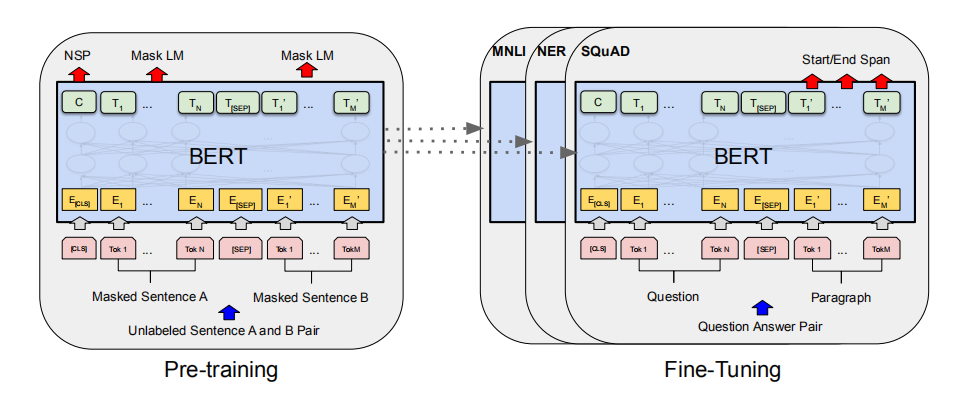
图1:BERT的总体预培训和微调过程。除了输出层之外，在预培训和微调中都使用了相同的架构。相同的预训练模型参数用于初始化不同下游任务的模型。在微调期间，所有参数都进行了微调。[CLS]是一个添加在每个输入示例前面的特殊符号，[SEP]是一个特殊的分隔符令牌(例如分隔问题/答案)

BERT的一个显著特征是它跨不同任务的统一架构。在预先训练的体系结构和最终的下游体系结构之间存在最小的差异。

BERT的模型结构是一种多层双向Transformer编码器，基于Vaswani等人描述的原始实现，并在tensor2张量库中发布。1 .由于Transformer的使用已经变得很普遍，我们的实现几乎与最初的实现相同，所以我们将省略对模型架构的详尽背景描述，并参考Vaswani等人(2017)以及优秀的指南，如“注释Transformer”。

在本工作中，我们表示层数(Transformer块)为L，隐藏尺寸为H，self-Attention头的数量为A。我们主要报告了两个模型尺寸的结果:基础BERT (L=12, H=768, A=12，总参数=110M)和大BERT (L=24, H=1024，A=16,总参数=340M)。

为了进行比较，选择基础BERT的与OpenAI GPT,模型大小相同。然而，关键的是，BERT Transformer使用双向的自我注意力机制，而GPT Transformer使用约束的自我注意，其中每个词只能注意其左边的上下文。

输入/输出表示为了让BERT处理各种下游任务，我们的输入表示能够在一个标记序列中明确地表示单个句子和一对句子(例如，问题、答案)。在工作中，一个“句子”可以是连续文本的任意跨度，而不是一个实际的语言句子。“序列”是指BERT的输入符号序列，它可以是一个句子或两个句子组合在一起。

我们使用带有30,000个令牌词汇表的词块嵌入。每个序列的第一个标记总是一个特殊的分类标记([CLS])。与此令牌对应的最终隐藏状态用作分类任务的聚合序列表示。句子对被组合成一个序列。我们用两种方法来区分这些句子。首先，我们用一个特殊的标记([SEP])将它们分开。其次，我们在每个标记中添加一个学习嵌入，表示它属于句子A还是句子B。如图1所示，我们将输入嵌入表示为E，即最终隐藏的值特殊[CLS]令牌的向量为C∈RH，第i个输入令牌的最终隐藏向量为Ti∈RH。

对于给定的令牌，它的输入表示通过对相应的令牌、段和位置嵌入求和来构造。图2显示了这种结构。

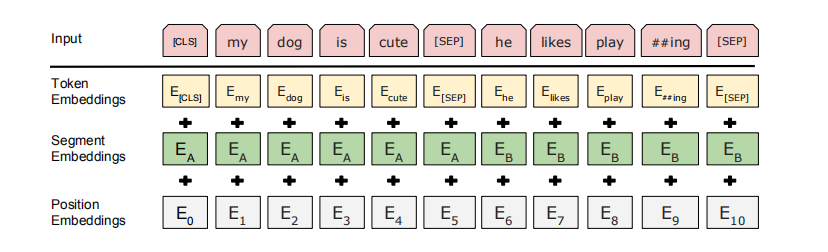
图2:BERT输入表示。输入嵌入是令牌嵌入、分段嵌入和位置嵌入的和。

## 3.1预训练BERT
不像Peters等人(2018a)和Radford等人(2018)，我们不使用传统的从左到右或从右到左的语言模型来预训练BERT。相反，我们使用两个非超视域任务对BERT进行预训练，本节将对此进行描述。此步骤在图1的左侧部分中显示。

任务#1:直观地Masked LM，我们有理由相信，深度双向模型严格地比从左到右的模型或从左到右和从右到左的模型的浅连接更强大。不幸的是，标准条件语言模型只能训练成从左到右或从右到左，因为双向条件作用可以让每个单词间接地“看到自己”，而且该模型可以在多层上下文中轻松地预测目标单词。

为了训练一个深层的双向表示，我们简单地随机屏蔽一定比例的输入令牌，然后预测这些屏蔽令牌。我们将这个过程称为“masked LM”(MLM)，尽管在文献中它经常被称为完形填空任务。在本例中，与掩码令牌对应的最终隐藏向量通过词汇表被输入到输出softmax中，就像在标准LM中一样。在我们所有的实验中，我们在每个序列中随机屏蔽15%的单词标记。与去噪的自动编码器相比，我们只预测掩蔽字，而不是重建整个输入。

尽管这允许我们获得双向的预训练模型，但缺点是我们在预训练和微调之间造成了不匹配，因为[MASK]令牌不会在微调期间出现。为了减轻这种情况，我们并不总是用实际的[MASK]令牌替换“masked”字。训练数据生成器随机选择令牌位置的15%进行预测。如果选择了第i个令牌，我们将用(1)80%的时间用[掩码]令牌替换第i个令牌(2)10%的时间用随机令牌替换第i个令牌(3)10%的时间用不变的第i个令牌替换第i个令牌。然后利用Ti来预测具有交叉熵损失的原始令牌。我们在附录C.2中比较了这一过程的变化。


任务#2:下一个句子预测(NSP)许多重要的下游任务，如问答(QA)和自然语言推理(NLI)，都是基于理解两个句子之间的关系，而语言建模并没有直接捕捉到这两个句子之间的关系。为了训练一个理解句子关系的模型，我们对一个可以由任何单语语料库生成的二值化下一个句子预测任务进行了预训练。具体来说，在为每个训练前示例选择句子A和句子B时，50%的时间B是A后面的实际下一个句子(标记为IsNext)， 50%的时间B是从语料库中随机抽取的句子(标记NotNext)。如图1所示，C用于下一个句子预测(NSP)。尽管它很简单，但我们在5.1节中说明，针对该任务的预训练对QA和NLI都非常有益。

NSP任务与Jernite et al.(2017)和Logeswaran and Lee(2018)中使用的表征性学习目标密切相关。然而，在以前的工作中，只有句嵌入被传输到下游任务，在那里BERT传输所有参数来初始化最终任务模型参数。

预训练数据 预训练程序在很大程度上遵循了现有的语言模型训练文献。预训练语料库使用图书语料库(8亿字)和英语维基百科(2500万字)。对于Wikipedia，我们只提取文本段落，而忽略列表、表和标题。为了提取长连续序列，关键是要使用文档级语料库，而不是像十亿词基准这样的句子级语料库。

## 3.2微调BERT
微调很简单，因为Transformer中的自我注意机制允许BERT通过交换适当的输入和输出来为许多下游任务建模——无论是单个文本还是文本对。对于涉及文本对的应用，一个常见的模式是在应用双向交叉注意之前对文本对进行独立编码，如Parikh等(2016);Seo等(2017)。相反，BERT使用了自我注意机制来统一这两个阶段，因为用自我注意编码一个连接的文本对有效地包含了两个句子之间的双向交叉注意。

对于每个任务，我们只需将特定于任务的输入和输出插入BERT中，并端到端微调所有参数。在输入端，预训练的句子A和句子B类似于(1)释义中的句子对，(2)隐含的假设-前提对，(3)问答中的问题-段落对，(4)文本分类或序列标注中的简并文本-∅对。在输出端，令牌表示被输入到一个输出层，用于令牌级别的任务，例如序列标记或问题回答，而[CLS]表示被输入到一个输出层，用于分类，例如需求分析或情绪分析。

与预训练相比，微调相对便宜。本文中的所有结果都可以在单个云TPU上最多1小时的时间内复制，或者在GPU上最多几个小时的时间内，从完全相同的预训练模型开始。我们在第4节的相应小节中描述了特定于任务的细节。更多细节见附录A.5。